# VinBigData Chest X-ray Abnormalities Detection

## ResNet101 model: Data Preprocessing, Fine-Tuning, Training and Inference

**Author: Théo LANGÉ** - s394369 - theo.lange.369@cranfield.ac.uk

This notebook describe the Resnet101 complete Pipeline for fine-tuning a pre-trained torchvision ResNet101 model on images classified as Normal or abnormal in order to detect whether an image present any abnormalities.

It requires as input the processed data obtained through the notebook `AI_VinBigData_Data_Preprocessing`. One could also access the resulting data directly on kaggle: 
> https://www.kaggle.com/datasets/theolange/ai-vinbigdata

For this notebook to work outside of kaggle, you will need to update the last cell in the `Setup` section to precise the path of all the needed directory. 

As of now, this pipeline will divide the train set into a train and validation set using the KFold method. One of the 5 fold created can be then used for validation. By default, the fold 4 will be used. You can change this by updating the parameter `VAL_FOLD` in the last cell of the `Setup` section.

## Table of contents
0. [Libraries and Setup](#0)
1. [Date Preprocessing](#1)
2. [DataLoaders & Datasets](#2)
3. [ResNet101 Model](#3)
    <br> 3.1. [Training utils](#7)</br>
    3.2. [Model](#8)
4. [Model Training & Validation](#4)
5. [Model Inference](#5)
6. [Save Model and Clean Working Directory](#6)

<a id="0"></a>
## 0. Libraries and Setup

In [1]:
import os
import sys
import shutil
from glob import glob
import time
import copy

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns

import cv2
from PIL import Image

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import sklearn

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, models, transforms


print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.13.0
Torchvision Version:  0.14.0


In [2]:
# Define the root data directory
DATA_DIR = "/kaggle/input/ai-vinbigdata"

# Define the paths to the training and testing dicom folders respectively
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

# Define paths to the relevant csv files
TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
TEST_CSV = os.path.join(DATA_DIR, "test_meta.csv")

# Working directory
WORKING_DIR = "/kaggle/working"

VAL_FOLD = 0
IMGSZ = 512

<a id="1"></a>
## 1. Data Preprocessing

In [3]:
train_df = pd.read_csv(TRAIN_CSV)
train_df.head(10)

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,img_original_height,img_original_width,x_min_resized,y_min_resized,x_max_resized,y_max_resized
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2580,2332,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,3159,2954,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2336,2080,180.0,301.0,390.0,401.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2880,2304,276.0,132.0,338.0,181.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,3072,2540,NaN,NaN,NaN,NaN
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,3072,2540,149.0,60.0,202.0,72.0
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,2555,2285,297.0,49.0,466.0,435.0
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,3353,2568,145.0,359.0,163.0,379.0
8,d3637a1935a905b3c326af31389cb846,Aortic enlargement,0,R10,1329.0,743.0,1521.0,958.0,2880,2304,287.0,132.0,322.0,170.0
9,afb6230703512afc370f236e8fe98806,Pulmonary fibrosis,13,R9,1857.0,1607.0,2126.0,2036.0,3072,2540,354.0,268.0,399.0,339.0


In [4]:
"""
The pipeline is only used in order to train a 2 class classifier to predict whether the test images may present at least one abnormality or not
Thus, only the image_id and class_id will be kept

Input: Train DataFrame
Output: Processed Train DataFrame
"""


def process_data (train_df):
    train_df = train_df[["image_id", "class_name", "class_id"]].copy()
    
    # Update class
    # Images have either No Finding or Finding annotations
    train_df['class_id'] = train_df.apply(lambda row: int(row.class_id==14), axis = 1)
    train_df['class_name'] = np.where(train_df['class_id']==0, 'Finding', 'No Finding')
    train_df = train_df.drop_duplicates().reset_index(drop=True)
    
    train_df['image_path'] = TRAIN_DIR + "/" + train_df.image_id +'.jpeg'
    return train_df

train_df = process_data(train_df)
train_df.head()

,image_id,class_name,class_id,image_path
0,50a418190bc3fb1ef1633bf9678929b3,No Finding,1,/kaggle/input/ai-vinbigdata/train/50a418190bc3...
1,21a10246a5ec7af151081d0cd6d65dc9,No Finding,1,/kaggle/input/ai-vinbigdata/train/21a10246a5ec...
2,9a5094b2563a1ef3ff50dc5c7ff71345,Finding,0,/kaggle/input/ai-vinbigdata/train/9a5094b2563a...
3,051132a778e61a86eb147c7c6f564dfe,Finding,0,/kaggle/input/ai-vinbigdata/train/051132a778e6...
4,063319de25ce7edb9b1c6b8881290140,No Finding,1,/kaggle/input/ai-vinbigdata/train/063319de25ce...


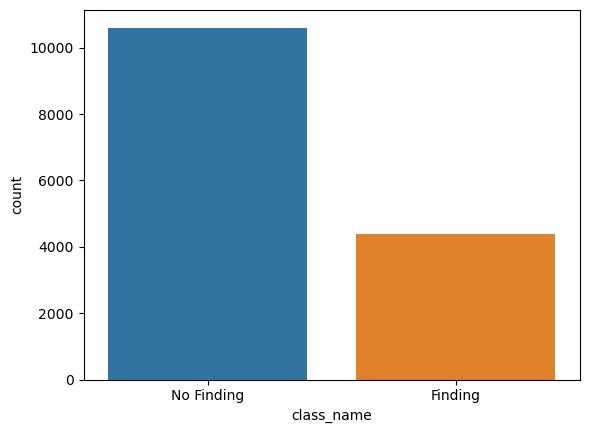

In [5]:
# Distribution of normal and abnormal images in the Train Dataset
sns.countplot(train_df, x="class_name");

The repartition of images is imbalanced between the two classes.

In [6]:
"""
Divide the Train Dataset into a training and a validation set.
Make sure the two classes are equally splitted using StratifiedKFold

Input: Train DataFrame
Output: DataFrame with all the images with no abnormalities and DataFrame with all the images with at least one abnormality
"""

def get_Fold(train_df):

    # Split the dataset and drop all the x-rays that do not contain any abnormality
    skf  = StratifiedKFold(n_splits = 5)
    train_df['fold'] = -1
    for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df.class_id.tolist())):
        train_df.loc[val_idx, 'fold'] = fold

    # Get the DataFrames for images with and without abnormalities
    normal_df = train_df[train_df.class_id == 1].reset_index(drop=True).copy()
    abnormal_df = train_df[train_df.class_id == 0].reset_index(drop=True).copy()
    
    return normal_df, abnormal_df

normal_df, abnormal_df = get_Fold(train_df)

In [7]:
"""
This function will copied every images into the right folder for training and validation

Input: DataFrame with all the images with no abnormalities and DataFrame with all the images with at least one abnormality
Output: None, files are copied into new folders for training and validation step
"""

def split_data(normal_df, abnormal_df, fold):

    # Create directory for each class
    os.makedirs(os.path.join(WORKING_DIR, 'train/No_Finding'), exist_ok = True)
    os.makedirs(os.path.join(WORKING_DIR, 'train/Finding'), exist_ok = True)
    os.makedirs(os.path.join(WORKING_DIR, 'val/No_Finding'), exist_ok = True)
    os.makedirs(os.path.join(WORKING_DIR, 'val/Finding'), exist_ok = True)


    val_files = list(normal_df[normal_df.fold==fold].image_path.unique())
    train_files = list(normal_df[normal_df.fold!=fold].image_path.unique())

    # Copy training images into right class directory
    for file in tqdm(train_files): # we use tqdm to see the progress of the copying of files
        shutil.copy(file, os.path.join(WORKING_DIR, 'train/No_Finding'))

    for file in tqdm(val_files):
        shutil.copy(file, os.path.join(WORKING_DIR, 'val/No_Finding'))


    val_files = list(abnormal_df[abnormal_df.fold==fold].image_path.unique())
    train_files = list(abnormal_df[abnormal_df.fold!=fold].image_path.unique())

    # Copy validation images into right class directory
    for file in tqdm(train_files): # we use tqdm to see the progress of the copying of files
        shutil.copy(file, os.path.join(WORKING_DIR, 'train/Finding'))

    for file in tqdm(val_files):
        shutil.copy(file, os.path.join(WORKING_DIR, 'val/Finding'))

split_data(normal_df, abnormal_df, VAL_FOLD)

  0%|          | 0/8484 [00:00<?, ?it/s]

  0%|          | 0/2122 [00:00<?, ?it/s]

  0%|          | 0/3516 [00:00<?, ?it/s]

  0%|          | 0/878 [00:00<?, ?it/s]

In [8]:
test_df = pd.read_csv(TEST_CSV)
test_df.head()

,image_id,img_height,img_width
0,002a34c58c5b758217ed1f584ccbcfe9,2584,2345
1,004f33259ee4aef671c2b95d54e4be68,3028,2517
2,008bdde2af2462e86fd373a445d0f4cd,2880,2304
3,009bc039326338823ca3aa84381f17f1,2430,1994
4,00a2145de1886cb9eb88869c85d74080,2408,2136


<a id="2"></a>
# 2. DataLoaders & Datasets

In [9]:
"""
Custom Class for the testing dataset
Return the transformed image and its id when called
"""

class CustomDataset(Dataset):
    def __init__(self, test_df, transform=None):
        self.test_df = test_df
        self.transform = transform
        
    def __getitem__(self, index):
        img_id = self.test_df.iloc[index, 0]
        image_path = os.path.join(TEST_DIR, img_id + '.jpeg')
        
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, img_id

    def __len__(self):
        return len(self.test_df)

In [10]:
"""
Create the training, validating and testing dataset with a transformation

Input: Test DataFrame
Output: Training, Validating and Testing DataSets
"""

def get_datasets(test_df):
    
    # Define the transformation to apply to the images
    transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Using ImageFolder for training and validating dataset
    train_dataset = datasets.ImageFolder(os.path.join(WORKING_DIR, 'train'), transform)
    val_dataset = datasets.ImageFolder(os.path.join(WORKING_DIR, 'val'), transform)
    
    test_dataset = CustomDataset(test_df, transform)
    
    return train_dataset, val_dataset, test_dataset

In [11]:
# Get the Datasets and print the classes
train_dataset, val_dataset, test_dataset = get_datasets(test_df)
print(train_dataset.class_to_idx)

{'Finding': 0, 'No_Finding': 1}


In [12]:
"""
Create PyTorch DataLoader with batches of size 16 for Training, Validation and Inference

Input: Training, Validating and Testing Dataset
Output: Training, Validating and Testing DataLoader
"""

def get_DataLoaders(train_dataset, val_dataset, test_dataset):
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=2)
    
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
    
    return train_dataloader, val_dataloader, test_dataloader

In [13]:
# Get the DataLoaders
train_dataloader, val_dataloader, test_dataloader = get_DataLoaders(train_dataset, val_dataset, test_dataset)

In [14]:
# Create a dictionnary to access Train and Validation DataLoader
dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

# Class id to Names
class_names = {0: 'Finding', 1: 'No Finding'}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

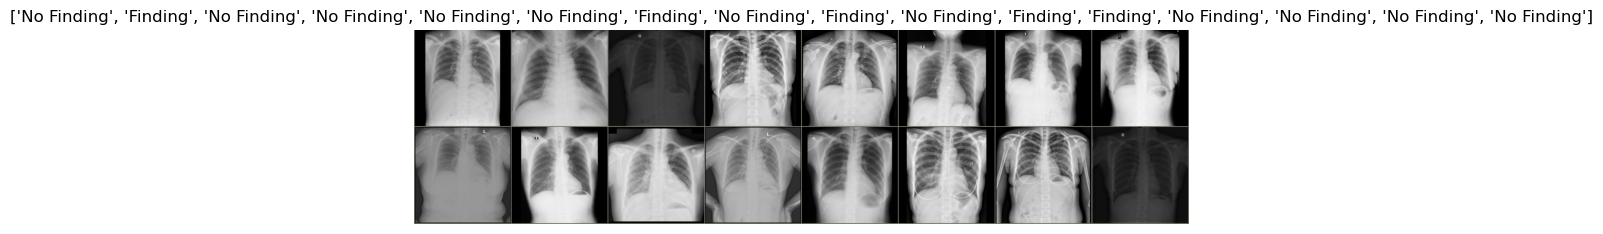

In [15]:
"""
Given a batch of images, plot the images and their labels

Input: A batch of images
Output: None, the Images and their classes will be displayed
"""

def imshow(inp, title=None):

    inp = inp.numpy().transpose((1, 2, 0))

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize=(10,10))
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.axis('off')
    
# Get a batch of the training data
inputs, classes = next(iter(dataloaders_dict['train']))

# Form a Grid with the images of the batch
out = torchvision.utils.make_grid(inputs)

# Apply the previous function on the grid for visualisation
imshow(out, title=[class_names[x] for x in classes.numpy()])

<a id="3"></a>
# 3. Resnet101 Model

<a id="7"></a>
## 3.1. Training Utils

In [16]:
"""
This function will fine-tuned the pre-trained ResNet101 model. At each step, both train and validation phase will be done
The fine-tuned is returned with the best model obtained through the epochs

Input: Model to train, DataLoaders dict with both training and validation set, an optimizer, a Learning Rate Scheduler and the number of epochs
Output: The Trained Model and the history of validation accuracy
"""

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    val_acc_history = []
    
    # Copy the best weights so far
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Training and Validation phase are done at each epochs 
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data in the dataloaders.
            for inputs, labels in dataloaders[phase]:
                # Send the input images and their labels to the working device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # Get the predicted class of the inputs
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics: Update the cumulated loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # Update the learning rate according to the scheduler
            if phase == 'train':
                scheduler.step()
            
            # Get the loss and accuracy over the epoch
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model best weights
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

<a id="8"></a>
## 3.2. Model

In [17]:
# Get the pre_trained ResNet101 model
model_ft = models.resnet101(weights='ResNet101_Weights.DEFAULT')
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

# Send the model to GPU
model_ft = model_ft.to(device)

# Criterion for loss computation
criterion = nn.CrossEntropyLoss()

# Define an Optimizer for the training stage
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Update the lr with Cosine Annealing with Warm restarts every 5 steps.
Cosine_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer_ft, T_0 = 5)

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

<a id="4"></a>
# 4. Model Training & Validation

In [18]:
# Train and evaluate the model
model_ft, hist_acc = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, Cosine_scheduler, num_epochs=15)

Epoch 0/14
----------
train Loss: 0.3114 Acc: 0.8647
val Loss: 0.1810 Acc: 0.9310

Epoch 1/14
----------
train Loss: 0.1784 Acc: 0.9297
val Loss: 0.1523 Acc: 0.9370

Epoch 2/14
----------
train Loss: 0.1099 Acc: 0.9592
val Loss: 0.1465 Acc: 0.9463

Epoch 3/14
----------
train Loss: 0.0635 Acc: 0.9786
val Loss: 0.1621 Acc: 0.9383

Epoch 4/14
----------
train Loss: 0.0424 Acc: 0.9862
val Loss: 0.1573 Acc: 0.9463

Epoch 5/14
----------
train Loss: 0.0731 Acc: 0.9721
val Loss: 0.1678 Acc: 0.9410

Epoch 6/14
----------
train Loss: 0.0450 Acc: 0.9842
val Loss: 0.1726 Acc: 0.9493

Epoch 7/14
----------
train Loss: 0.0274 Acc: 0.9916
val Loss: 0.1904 Acc: 0.9490

Epoch 8/14
----------
train Loss: 0.0123 Acc: 0.9966
val Loss: 0.1930 Acc: 0.9503

Epoch 9/14
----------
train Loss: 0.0084 Acc: 0.9977
val Loss: 0.1932 Acc: 0.9517

Epoch 10/14
----------
train Loss: 0.0164 Acc: 0.9943
val Loss: 0.2198 Acc: 0.9483

Epoch 11/14
----------
train Loss: 0.0162 Acc: 0.9947
val Loss: 0.2265 Acc: 0.9453

Ep

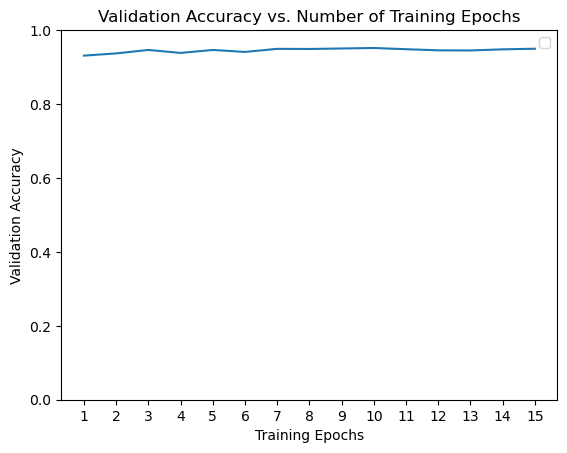

In [19]:
"""
Plot the validation accuracy over the epochs

Input: Validation Accuracy history
Output: None, the validation accuracy history will be displayed
"""

def plot_val_acc(hist_acc):

    # Get the history on CPU
    history_acc = [float(h.cpu().numpy()) for h in hist_acc]

    # Display accuracy history
    plt.title("Validation Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Validation Accuracy")
    plt.plot(range(1,len(history_acc)+1),history_acc)
    plt.ylim((0,1.))
    plt.xticks(np.arange(1, len(history_acc)+1, 1.0))
    plt.legend()
    plt.show();

plot_val_acc(hist_acc)

In [20]:
"""
Display the Confusion Matrix

Input: The fine-tuned model, DataLoaders dict with the validation DataLoader
Output: None, it will display the confusion matrix for the validation set
"""

def display_confusion_matrix(model_ft, dataloaders):

    # Set model to eval mode
    was_training = model_ft.training
    model_ft.eval()
    
    y_pred = []
    y_true = []

    # Iterate over validation data
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Get the outputs
            outputs = model_ft(inputs)

            # Get predicted class
            output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(output) 
            
            # Get True class
            labels = labels.data.cpu().numpy()
            y_true.extend(labels) 
        
        model_ft.train(mode=was_training)


    # Determine and plot Confusion Matrix
    Conf_M = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred, normalize='true'), display_labels=['Finding','No Finding'])
    Conf_M.plot(cmap='Blues');

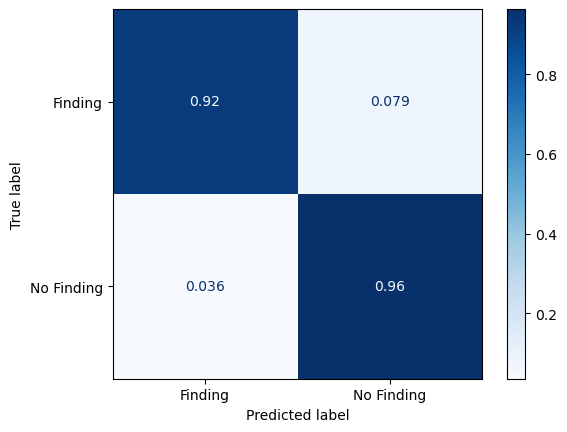

In [21]:
# Confusion Matrix
display_confusion_matrix(model_ft, dataloaders_dict)

In [22]:
"""
Display the ROC curve and the ROC_AUC score

Input: Fine-tuned Model, DataLoaders dict with the validation DataLoader
Output: None, displays the ROC curve and the ROC_AUC score
"""

def display_roc_curve(model_ft, dataloaders):

    # Set model to eval mode
    was_training = model_ft.training
    model_ft.eval()
    
    # Initialise lists
    y_true = []
    y_pred = []

    # Iterate over validation data
    with torch.no_grad():

        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Get True labels
            labels = labels.data.cpu().numpy()
            y_true.extend(labels)

            # Get prediction scores
            scores = model_ft(inputs).softmax(1)
            
            # Save Predicted label
            for i in range(len(scores)):
                y_pred.append(torch.max(scores[i]).item())
        
        model_ft.train(mode=was_training)

    # Determine false_positive and true_positive ratios
    fpr, tpr, _ = roc_curve(y_true, y_pred)

    # Compute AUC score
    auc = roc_auc_score(y_true, y_pred)

    # Display ROC curve and ROC_AUC score
    plt.figure(figsize=(8,6))
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.show()

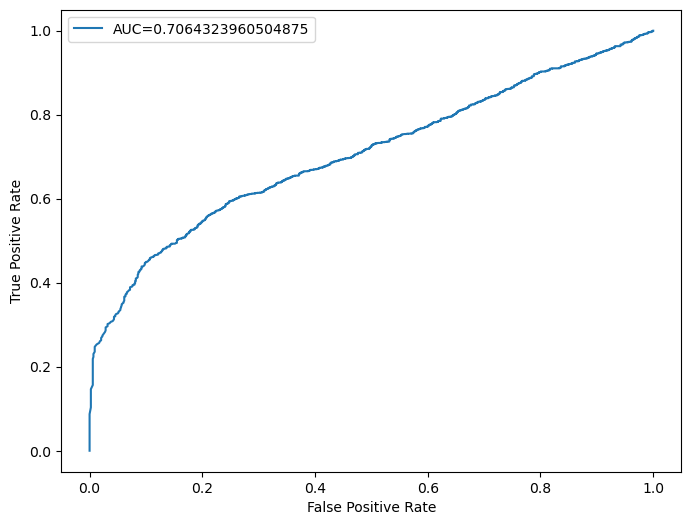

In [23]:
display_roc_curve(model_ft, dataloaders_dict)

<a id="5"></a>
# 5. Model Inference

In [24]:
"""
For each images, infer prediction score for both classes

Input: Fine-tuned model, Test DataLoader
Output: Prediction DataFrame with prediction score of each class for each images in the test set
"""

def inference(model_ft, test_dataloader):  

    # Set model to eval mode
    model_ft.eval()   
    predictions = []

    with torch.no_grad():
    # Iterate over data.
        for images, image_ids in test_dataloader:
            inputs = images.to(device)           
            
            scores = model_ft(inputs).softmax(1)

            # For each images, retrieve both labels score
            for i, image in enumerate(images):
                image_id = image_ids[i]
                score = scores[i].cpu().numpy()
                predictions.append([image_id, score[0], score[1]])

    # Create the prediction DataFrame
    pred_df = pd.DataFrame({
        'image_id': np.array(predictions)[:,0],
        'Finding': np.array(predictions)[:,1],
        'No Finding':np.array(predictions)[:,2]
    })
    
    return pred_df.sort_values(by='image_id').reset_index(drop=True)

In [25]:
# Make inference on Test Set using the Fine-tuned model
pred_df = inference(model_ft, test_dataloader)
pred_df.head()

,image_id,Finding,No Finding
0,002a34c58c5b758217ed1f584ccbcfe9,4.757216e-06,0.99999523
1,004f33259ee4aef671c2b95d54e4be68,0.00010833276,0.99989164
2,008bdde2af2462e86fd373a445d0f4cd,0.98320466,0.016795361
3,009bc039326338823ca3aa84381f17f1,0.000928376,0.9990716
4,00a2145de1886cb9eb88869c85d74080,0.9887066,0.011293429


In [26]:
pred_df.to_csv("Resnet101_2cls_pred.csv", index=False)

<a id="6"></a>
# 6. Save Model and Clean Working Directory

In [27]:
# Save Model weights
torch.save(model_ft.state_dict(), os.path.join(WORKING_DIR, "ResNet101_best_model.pt"))

In [28]:
# Remove the directory created for the training and validating stage
shutil.rmtree(os.path.join(WORKING_DIR, 'train'))
shutil.rmtree(os.path.join(WORKING_DIR, 'val'))